## 한국인 감정인식을 위한 복합영상데이터셋

Valid 를 우리의 clean data로,
train 4을 우리의 external validaiton data로 사용함

압축풀기

In [ ]:
!unzip /content/drive/MyDrive/clean_0317/External/ext_anger.zip -d /content/drive/MyDrive/clean_0317/External/ext_anger/
!unzip /content/drive/MyDrive/clean_0317/External/ext_happy.zip -d /content/drive/MyDrive/clean_0317/External/ext_happy/
!unzip /content/drive/MyDrive/clean_0317/External/ext_sad.zip -d /content/drive/MyDrive/clean_0317/External/ext_sad/
!unzip /content/drive/MyDrive/clean_0317/External/ext_disgust.zip -d /content/drive/MyDrive/clean_0317/External/ext_disgust/
!unzip /content/drive/MyDrive/clean_0317/External/ext_fear.zip -d /content/drive/MyDrive/clean_0317/External/ext_fear/
!unzip /content/drive/MyDrive/clean_0317/External/ext_fear_+10.zip -d /content/drive/MyDrive/clean_0317/External/ext_fear/
!unzip /content/drive/MyDrive/clean_0317/External/ext_surprise.zip -d /content/drive/MyDrive/clean_0317/External/ext_surprise/
!unzip /content/drive/MyDrive/clean_0317/External/ext_neutral.zip -d /content/drive/MyDrive/clean_0317/External/ext_neutral/

# 사진 크롭 및 저장

In [ ]:
#사진을 크롭해서 저장하는 코드
import os
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import concurrent.futures

# mediapipe 초기화
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.4)

# 감정 라벨과 해당하는 디렉토리 매핑
emotion_directories = {
    "anger": "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_anger",
    "disgust": "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_disgust",
    "fear": "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_fear",
    "happy": "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_happy",
    "neutral": "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_neutral",
    "sad": "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_sad",
    "surprise": "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_surprise"
}

# 감정 라벨과 해당하는 정수 매핑
emotion_labels = {
    "happy": 0,
    "sad": 1,
    "anger": 2,
    "surprise": 3,
    "disgust": 4,
    "neutral": 5,
    "fear": 6,
}

# TFRecord 특성 생성 함수들
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 폴더 경로에서 감정 라벨을 추출하여 해당 정수를 반환하는 함수
def get_label(folder_path):
    for emotion, label in emotion_labels.items():
        if emotion in folder_path:
            return label
    return -1

# 얼굴 회전 감지 및 정렬 함수
def correct_rotation(image):
    # 얼굴 감지
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.detections:
        for detection in results.detections:
            #얼굴 랜드마크 추출
            landmarks = detection.location_data.relative_keypoints
            left_eye = landmarks[0]
            right_eye = landmarks[1]

            # 눈의 위치를 사용하여 회전 각도 계산
            left_eye_pos = (left_eye.x * image.shape[1], left_eye.y * image.shape[0])
            right_eye_pos = (right_eye.x * image.shape[1], right_eye.y * image.shape[0])
            dy = right_eye_pos[1] - left_eye_pos[1]
            dx = right_eye_pos[0] - left_eye_pos[0]
            angle = np.degrees(np.arctan2(dy, dx))

            # 회전 행렬 생성 및 이미지 회전
            center = (image.shape[1] // 2, image.shape[0] // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1)
            rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
            return rotated_image
    return None  # 얼굴 감지 실패 시 None 반환

# 이미지 처리 및 TFRecord 파일 생성 함수
def process_image(image_file, writer, total_images, current_count):
    try:
        image = cv2.imread(image_file)
        if image is None:
            return

        # 이미지 회전 감지 및 정렬
        corrected_image = correct_rotation(image)
        if corrected_image is None:
            return
        # 얼굴 탐지
        results = face_detection.process(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
        if not results.detections:
            return
        # 얼굴 주위에 사각형 그리기 및 크롭
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = corrected_image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

                # 이미지를 크롭
                cropped_image = corrected_image[y:y+h, x:x+w]
                # 크롭된 이미지의 크기를 48x48으로 변경
                resized_cropped_image = cv2.resize(cropped_image, (128, 128))
                # TFRecord에 저장할 특성 정의 및 저장
                feature = {
                    "image": _bytes_feature(resized_cropped_image),
                    "label": _int64_feature(get_label(image_file)),
                }
                example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example_proto.SerializeToString())

    except Exception as e:
        print(f"Error processing image {image_file}: {e}")

    # 현재 진행 상황 출력
    print(f"Processed {current_count}/{total_images} images")

# 각 디렉토리에 대해 반복 실행
for emotion, dir_path in emotion_directories.items():

    image_files = [
        os.path.join(dir_path, filename)
        for filename in os.listdir(dir_path)
        if filename.endswith((".jpg", ".png", ".jpeg"))
    ]

    # TFRecord 파일 이름 설정
    output_dir = "/content/drive/MyDrive/clean_0317/External/train_valid_test_all_128"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    tfrecord_filename = os.path.join(output_dir, f"ext_{emotion}.tfrecord")

    with tf.io.TFRecordWriter(tfrecord_filename) as writer:
        for count, image_file in enumerate(image_files, start=1):
            process_image(image_file, writer, len(image_files), count)

# Train test split 저장

In [ ]:
import tensorflow as tf
import functools
def split_tfrecord(tfrecord_path, train_ratio, val_ratio):
    # 데이터셋 로드
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset_size = sum(1 for _ in dataset)

    # 각 데이터셋의 크기 계산
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # 데이터셋 분할
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

def write_tfrecord(dataset, filename):
    writer = tf.io.TFRecordWriter(filename)
    for record in dataset:
        writer.write(record.numpy())
    writer.close()

def concatenate_datasets(datasets):
    # functools.reduce를 사용하여 데이터셋들을 순차적으로 병합
    return functools.reduce(lambda a, b: a.concatenate(b), datasets)

# 파일 경로 설정
file_paths = [
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/clean_NOAUG_anger.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/clean_NOAUG_disgust.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/clean_NOAUG_fear.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/clean_NOAUG_happy.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/clean_NOAUG_neutral.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/clean_NOAUG_sad.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/clean_NOAUG_surprise.tfrecord'
]

# 빈 데이터셋 생성
train_datasets, val_datasets, test_datasets = [], [], []

# 각 파일 처리
for file_path in file_paths:
    train, val, test = split_tfrecord(file_path, 0.75, 0.15)
    train_datasets.append(train)
    val_datasets.append(val)
    test_datasets.append(test)

# 데이터셋 병합
train_dataset = concatenate_datasets(train_datasets)
val_dataset = concatenate_datasets(val_datasets)
test_dataset = concatenate_datasets(test_datasets)

# 새로운 TFRecord 파일로 저장
write_tfrecord(train_dataset, '/content/drive/MyDrive/clean_0317/External/clean_NOLAND_train.tfrecord')
write_tfrecord(val_dataset, '/content/drive/MyDrive/clean_0317/External/clean_NOLAND_val.tfrecord')
write_tfrecord(test_dataset, '/content/drive/MyDrive/clean_0317/External/clean_NOLAND_test.tfrecord')


# *Train test split 저장 
--> external validation은 test set에 모두 저장

In [ ]:
import tensorflow as tf
import functools

def read_tfrecord(tfrecord_path):
    # 단순히 데이터셋을 로드하여 반환
    return tf.data.TFRecordDataset(tfrecord_path)

def write_tfrecord(dataset, filename):
    writer = tf.io.TFRecordWriter(filename)
    for record in dataset:
        writer.write(record.numpy())
    writer.close()

def concatenate_datasets(datasets):
    # functools.reduce를 사용하여 데이터셋들을 순차적으로 병합
    return functools.reduce(lambda a, b: a.concatenate(b), datasets)

# 파일 경로 설정
file_paths = [
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/ext_anger.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/ext_disgust.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/ext_fear.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/ext_happy.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/ext_neutral.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/ext_sad.tfrecord',
    '/content/drive/MyDrive/clean_0317/External/train_valid_test_all/ext_surprise.tfrecord'
]

# 빈 데이터셋 리스트 생성
test_datasets = []

# 각 파일을 읽어서 test 데이터셋 리스트에 추가
for file_path in file_paths:
    dataset = read_tfrecord(file_path)
    test_datasets.append(dataset)

# 데이터셋 병합
test_dataset = concatenate_datasets(test_datasets)

# 새로운 TFRecord 파일로 저장
write_tfrecord(test_dataset, '/content/drive/MyDrive/clean_0317/External/ext_NOLAND_test.tfrecord')


# Train augmentation
external은 augmentation 안함

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TFRecord 파일에서 이미지와 라벨 추출
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(parsed_features['image'])
    label = parsed_features['label']
    return image, label

# 이미지 증강 함수 정의
def augment_image(image, datagen):
    # 이미지를 배치 형태로 변경 (1, height, width, channels)
    image = np.expand_dims(image, 0)
    # 이미지 데이터 생성기에 이미지를 전달
    it = datagen.flow(image, batch_size=1)
    # 증강된 이미지를 생성
    image_aug = it.next()
    # 배치 차원을 제거하고 이미지 반환
    return image_aug[0]
def write_augmented_tfrecord(input_tfrecord_path, output_tfrecord_path, datagen):
    with tf.io.TFRecordWriter(output_tfrecord_path) as writer:
        for raw_record in tf.data.TFRecordDataset(input_tfrecord_path):
            image, label = parse_tfrecord_fn(raw_record)

            # 원본 이미지 저장
            image_string = tf.io.encode_jpeg(tf.cast(image, tf.uint8)).numpy()
            original_feature = {
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()])),
            }
            original_example = tf.train.Example(features=tf.train.Features(feature=original_feature))
            writer.write(original_example.SerializeToString())

            # 증강된 이미지 저장
            image_aug = augment_image(image.numpy(), datagen)
            image_string_aug = tf.io.encode_jpeg(tf.cast(image_aug, tf.uint8)).numpy()
            augmented_feature = {
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string_aug])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()])),
            }
            augmented_example = tf.train.Example(features=tf.train.Features(feature=augmented_feature))
            writer.write(augmented_example.SerializeToString())
# ImageDataGenerator 정의
datagen = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
train_tfrecord_path = '/content/drive/MyDrive/clean_0317/Dataset_clean/ext_NOLAND_train.tfrecord'

# 증강된 이미지를 저장할 새로운 TFRecord 파일 경로
augmented_tfrecord_path = '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_NOLAND_train_augmented.tfrecord'

# 증강된 데이터를 새로운 TFRecord 파일에 저장
write_augmented_tfrecord(train_tfrecord_path, augmented_tfrecord_path, datagen)
# 증강된 데이터를 새로운 TFRecord 파일에 저장

# 데이터 셔플
external은 testset을 셔플함

In [ ]:
import tensorflow as tf

# TFRecord 파싱 함수
def _parse_function(proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "landmarks": tf.io.VarLenFeature(tf.float32),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(proto, feature_description)

# 특성을 tf.train.Feature로 변환하는 함수
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList는 EagerTensor에서 바이트 문자열을 처리하지 않습니다.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 원본 TFRecord 파일 경로
original_tfrecord_path = '/content/drive/MyDrive/clean_0317/External/ext_NOLAND_test.tfrecord'

# TFRecord 데이터셋 로드 및 파싱
raw_dataset = tf.data.TFRecordDataset(original_tfrecord_path)
parsed_dataset = raw_dataset.map(_parse_function)

# 데이터셋 셔플
shuffled_dataset = parsed_dataset.shuffle(buffer_size=100000)

# 새로운 TFRecord 파일로 저장
new_tfrecord_path = '/content/drive/MyDrive/clean_0317/External/ext_NOLAND_test_shuffled.tfrecord'
with tf.io.TFRecordWriter(new_tfrecord_path) as writer:
    for parsed_record in shuffled_dataset:
        features = {
            "image": _bytes_feature(parsed_record["image"]),
            "label": _int64_feature(parsed_record["label"])
        }
        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())


# 랜드마크 추출
train test val 모두 진행
external도 함

In [ ]:
import os
import cv2
import numpy as np
import logging
import tensorflow as tf
import mediapipe as mp
from google.colab.patches import cv2_imshow

# 로깅 설정
logging.basicConfig(filename="error_log.txt", level=logging.ERROR)

# mediapipe 초기화
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.2)
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# .tfrecord 파일 경로 설정
tfrecord_file_path = '/content/drive/MyDrive/clean_0317/External/ext_NOLAND_test_shuffled.tfrecord'
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# TFRecord 파싱 함수
def parse_tfrecord_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    return tf.io.parse_single_example(example_proto, feature_description)

# 이미지 디코딩 함수
def decode_image(image_str):
    image = tf.image.decode_jpeg(image_str, channels=3)
    return image.numpy()  # TensorFlow 텐서를 NumPy 배열로 변환

# TFRecord 파일 로드 및 파싱
raw_dataset = tf.data.TFRecordDataset(tfrecord_file_path)
parsed_dataset = raw_dataset.map(parse_tfrecord_function)

# 이미지 데이터와 라벨을 담을 리스트
image_data = []

# 각 레코드 처리
for parsed_record in parsed_dataset:
    image_str = parsed_record['image'].numpy()
    image = decode_image(image_str)
    label = parsed_record['label'].numpy()
    image_data.append((image, label))

# TFRecord에 저장할 랜드마크 좌표 저장 함수
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def get_landmarks(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    if results.multi_face_landmarks:
        landmarks = []
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])
        return landmarks
    return []

def process_image(image_data, writer):
    for i, (image, label) in enumerate(image_data):
        try:
            if image is None:
                logging.error("Error processing image: Image is None")
                continue
            # 얼굴 랜드마크 추출
            landmarks = get_landmarks(image)
            # TFrecord에 저장할 특성 정의 및 저장
            feature = {
                "image": _bytes_feature(image),
                "landmarks": _float_feature(landmarks),
                "label": _int64_feature(label)
            }
            example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example_proto.SerializeToString())
            progress = (i + 1) / len(image_data) * 100
            print(f"Processing image {i + 1}/{len(image_data)} ({progress:.2f}%)")
        except Exception as e:
            logging.error(f"Error processing image: {e}", exc_info=True)

# TFRecord 파일 생성 및 이미지 처리
output_tfrecord_file_path = '/content/drive/MyDrive/clean_0317/External/ext_NO_Z_test_shuffled.tfrecord'
with tf.io.TFRecordWriter(output_tfrecord_file_path) as writer:
    process_image(image_data, writer)


# 이미지, 랜드마크 시각화
YES AUG

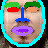

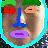

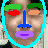

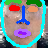

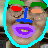

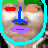

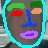

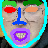

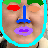

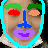

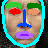

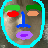

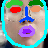

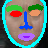

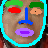

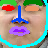

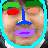

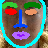

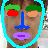

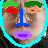

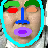

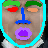

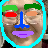

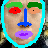

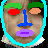

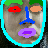

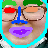

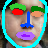

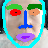

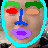

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
import logging

# TFRecord 파싱 함수
def _parse_function(proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "landmarks": tf.io.VarLenFeature(tf.float32),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    return parsed_features

# 이미지 디코딩 함수
def decode_image(image_str):
    image = tf.image.decode_image(image_str, channels=3)
    return image

# TFRecord 파일 로드
raw_dataset = tf.data.TFRecordDataset("/content/drive/MyDrive/clean_0317/Dataset_clean/clean_NO_Z_train.tfrecord")
parsed_dataset = raw_dataset.map(_parse_function)

# 주요 랜드마크 인덱스 및 색상
landmark_colors = {
    "Left Eyebrow": ([70,63,105,66,107,55,65,52,53,46,70], (50, 205, 50)),
    "Right Eyebrow": ([300,293,334,296,336,285,295,282,283,276,300], (0, 128, 0)),
    "Left Eye": ([33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7,33], (0, 0, 255)),
    "Right Eye": ([263,466,388,387,386,385,384,398,362,382,381,380,374,373,390,249,263], (100, 149, 237)),
    "Inner Lip": ([78,191,80,81,82,13,312,311,310,415,308,324,318,402,317,14,87,178,88,95,78], (255, 20, 147)),
    "Outer Lip": ([61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146,61], (255, 105, 180)),
    "Face Boundary": ([10,338,297,332,284,251,389,356,454,323,361,288,397,365,379,378,400,377,152,148,176,149,150,136,172,58,132,93,234,127,162,21,54,103,67,109,10], (255, 255, 0)),
    "Nose": ([64,4,294], (255, 69, 0)),
    "Nose Bridge": ([168,6,197,195,5,4,1],(255,69,0))
}

# TFRecord 데이터셋 순회 및 랜드마크 시각화
for idx, parsed_record in enumerate(parsed_dataset.take(30)):
    image_str = parsed_record["image"].numpy()
    image = decode_image(image_str).numpy()

    # TFRecord에서 랜드마크 좌표 추출
    landmarks = tf.sparse.to_dense(parsed_record["landmarks"]).numpy()
    annotated_image = image.copy()

    # TFRecord의 랜드마크 좌표를 기반으로 랜드마크 표시
    for label, (indices, label_color) in landmark_colors.items():
        landmark_points = [(int(landmarks[i * 3] * image.shape[1]), int(landmarks[i * 3 + 1] * image.shape[0])) for i in indices]
        for point in landmark_points:
            cv2.circle(annotated_image, point, 1, label_color, -1)

        # 랜드마크 연결선 그리기
        for i in range(len(landmark_points) - 1):
            cv2.line(annotated_image, landmark_points[i], landmark_points[i+1], label_color, 2)

    cv2_imshow(annotated_image)  # 이미지를 노트북에서 표시

#랜드마크길이출력_디버깅용
YES AUG

In [ ]:
import tensorflow as tf

tfrecord_file = '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_NO_Z_train.tfrecord'

# TFRecord 파일에서 데이터 읽기 및 파싱
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'landmarks': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(example, feature_description)
    landmarks = parsed_features['landmarks'].values
    return parsed_features['image'], landmarks, parsed_features['label']

# 원본 데이터셋
original_dataset = tf.data.TFRecordDataset(tfrecord_file).map(parse_tfrecord_fn)

# 데이터 필터링 함수
def filter_data(image, landmarks, label):
    # landmarks의 크기가 468*3인지 확인
    return tf.equal(tf.shape(landmarks)[0], 468*3)

# 필터링된 데이터셋
filtered_dataset = original_dataset.filter(lambda x, y, z: filter_data(x, y, z))

# 랜드마크 필드의 길이 확인 및 출력
for image, landmarks, label in filtered_dataset:
    print("랜드마크 필드의 길이:", tf.shape(landmarks)[0].numpy())


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길이: 1404
랜드마크 필드의 길

# Z_value 저장
external도 함

In [ ]:
#셔플된거 zvalue 계산해서 저장하는 코드
import random
import math
import tensorflow as tf
import numpy as np


# 감정 레이블 정의
emotion_labels = {
    "happy": 0, "sad": 1, "anger": 2, "surprise": 3, "disgust": 4, "neutral": 5, "fear": 6,
}

# TFRecord 파일 경로
tfrecord_file = '/content/drive/MyDrive/clean_0317/External/ext_NO_Z_test_shuffled.tfrecord'

# TFRecord 파일에서 데이터 읽기
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'landmarks': tf.io.VarLenFeature(tf.float32),  # 변경된 부분
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_features = tf.io.parse_single_example(example, feature_description)
    image = parsed_features['image']
    landmarks = tf.sparse.to_dense(parsed_features['landmarks'])  # 변경된 부분
    label = parsed_features['label']
    return image, landmarks, label



# 데이터 필터링 함수
def filter_data(image, landmarks, label):
    # landmarks의 크기가 468*3인지 확인
    return tf.shape(landmarks)[0] == 468*3

# 원본 데이터셋
original_dataset = tf.data.TFRecordDataset(tfrecord_file).map(parse_tfrecord_fn)

# 필터링된 데이터셋
filtered_dataset = original_dataset.filter(filter_data)

# 거리 계산 함수
def calculate_distance(p1, p2):
    return tf.sqrt(tf.reduce_sum(tf.square(p1 - p2)))

# z1-z9 값 계산
def calculate_z_values(xyz_coordinates):
    z_values = {}
    # z1 계산
    z1_numerator = calculate_distance(xyz_coordinates[78], xyz_coordinates[308])
    z1_denominator = calculate_distance(xyz_coordinates[14], xyz_coordinates[13])
    z_values['z1'] = z1_numerator / z1_denominator

    # z2 계산
    z2_numerator = calculate_distance(xyz_coordinates[33], xyz_coordinates[133])
    z2_denominator = calculate_distance(xyz_coordinates[160], xyz_coordinates[144])
    z_values['z2'] = z2_numerator / z2_denominator

    # z3 계산
    z3_numerator = calculate_distance(xyz_coordinates[107], xyz_coordinates[46])
    z3_denominator = calculate_distance(xyz_coordinates[107], xyz_coordinates[133])
    z_values['z3'] = z3_numerator / z3_denominator

    # z5 계산
    z5_numerator = calculate_distance(xyz_coordinates[107], xyz_coordinates[306])
    z5_denominator = calculate_distance(xyz_coordinates[133], xyz_coordinates[362])
    z_values['z5'] = z5_numerator / z5_denominator

    # z6 계산
    z6_numerator = calculate_distance(xyz_coordinates[2], xyz_coordinates[0])
    z6_denominator = calculate_distance(xyz_coordinates[2], xyz_coordinates[57])
    z_values['z6'] = z6_numerator / z6_denominator

    # z7 계산
    z7_numerator = calculate_distance(xyz_coordinates[57], xyz_coordinates[287])
    z7_denominator = calculate_distance(xyz_coordinates[60], xyz_coordinates[290])
    z_values['z7'] = z7_numerator / z7_denominator

    # z8 계산
    z8_numerator = calculate_distance(xyz_coordinates[60], xyz_coordinates[290])
    z8_denominator = calculate_distance(xyz_coordinates[6], xyz_coordinates[4])
    z_values['z8'] = z8_numerator / z8_denominator

    # z9 계산
    z9_numerator = calculate_distance(xyz_coordinates[160], xyz_coordinates[0])
    z9_denominator = calculate_distance(xyz_coordinates[160], xyz_coordinates[57])
    z_values['z9'] = z9_numerator / z9_denominator

    z_values_list = [z_values[key] for key in sorted(z_values.keys())]
    return z_values_list

# 데이터에서 z1-z9 값을 추출하는 함수
def process_data(image, landmarks, label):
    landmarks = tf.reshape(landmarks, (468, 3))
    z_values = calculate_z_values(landmarks)
    return image, landmarks, z_values, label

# 처리된 데이터셋
processed_dataset = filtered_dataset.map(process_data)

# TFRecord 파일로 저장할 경로
tfrecord_filename = '/content/drive/MyDrive/clean_0317/External/ext_YES_Z_test_shuffled.tfrecord'

# TFRecord 파일 저장 함수
def serialize_combined_example(image, landmarks, z_values, label):
    # 이미지를 JPEG 형식으로 인코딩하고 numpy 바이트 배열로 변환
    image_encoded = tf.io.encode_jpeg(tf.io.decode_jpeg(image)).numpy()

    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_encoded])),
        'landmarks': tf.train.Feature(float_list=tf.train.FloatList(value=landmarks.numpy().flatten())),
        'z_values': tf.train.Feature(float_list=tf.train.FloatList(value=z_values)),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()]))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# TFRecord 파일에 데이터 저장
with tf.io.TFRecordWriter(tfrecord_filename) as writer:
    for image, landmarks, z_values, label in processed_dataset:
        serialized_data = serialize_combined_example(image, landmarks, z_values, label)
        writer.write(serialized_data)

# 이미지, 랜드마크, z_value 시각화
아래는 AUGX로 해봄, YES AUG도 해봤는데 잘 나옴

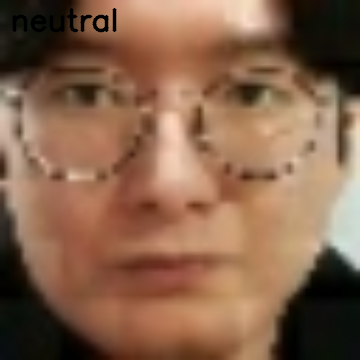

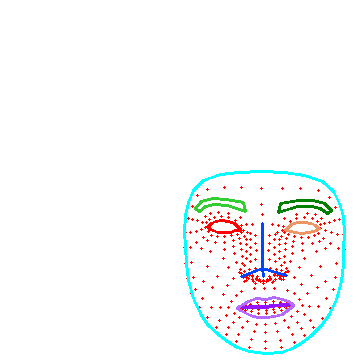

z_values: [84.26421     3.198003    1.4937085   2.5692263   0.33716     3.2432802
  0.54075664  1.1035252 ]
Emotion Label: neutral


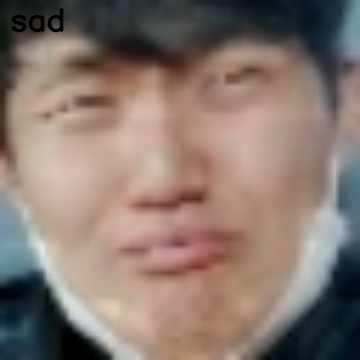

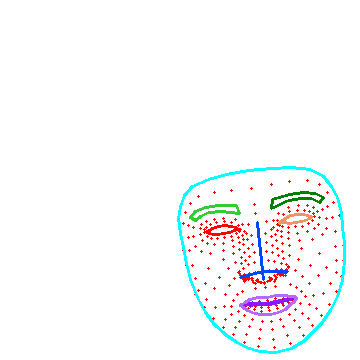

z_values: [33.227863    4.2100916   1.49073     2.6950066   0.30405003  3.0187116
  0.576325    1.110712  ]
Emotion Label: sad


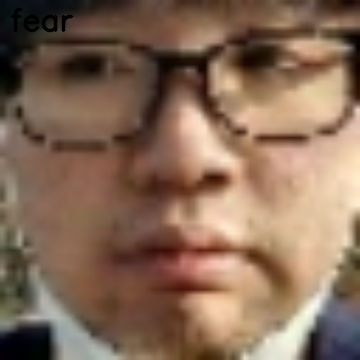

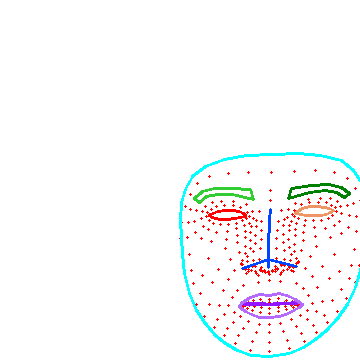

z_values: [27.507109    4.3605485   1.599307    2.5663323   0.35937315  3.032153
  0.60442215  1.0770111 ]
Emotion Label: fear


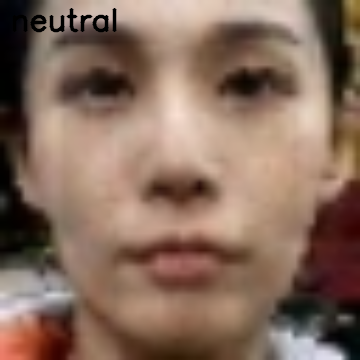

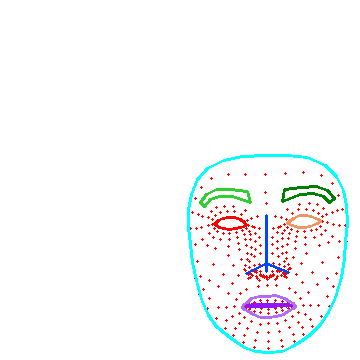

z_values: [32.02205     3.288406    1.3003589   3.0352943   0.36161488  3.3003013
  0.4841194   1.0543013 ]
Emotion Label: neutral


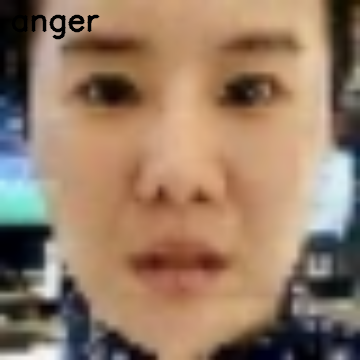

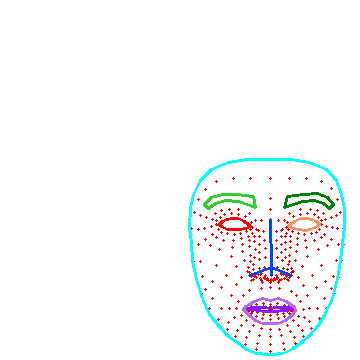

z_values: [11.91801     3.2685945   1.3763857   3.1728535   0.36715052  3.1945708
  0.4986481   1.0435185 ]
Emotion Label: anger


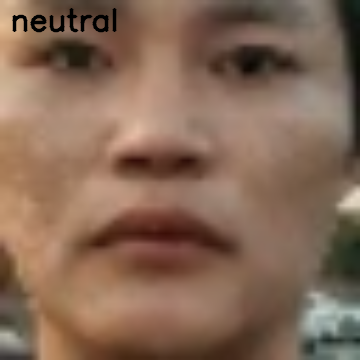

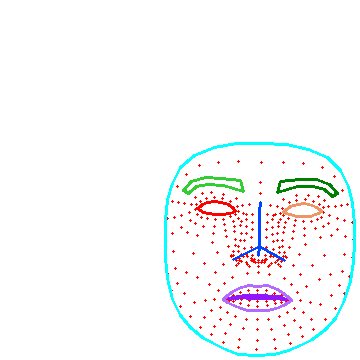

z_values: [24.398495    3.4915962   1.5903319   2.707553    0.34230676  3.527024
  0.53291386  1.076845  ]
Emotion Label: neutral


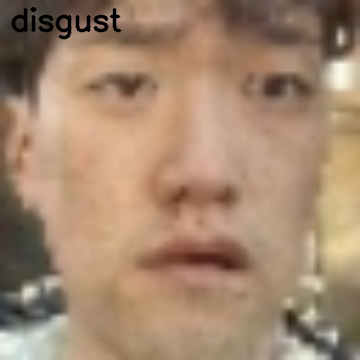

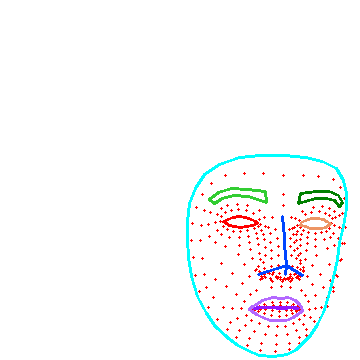

z_values: [56.338963    3.8777475   1.4496909   2.9130406   0.331123    3.079125
  0.50794077  1.0507609 ]
Emotion Label: disgust


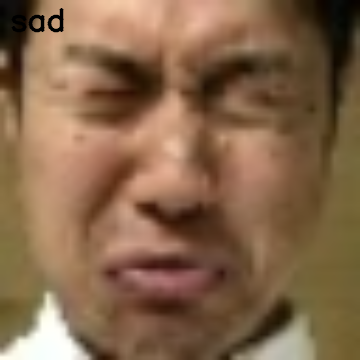

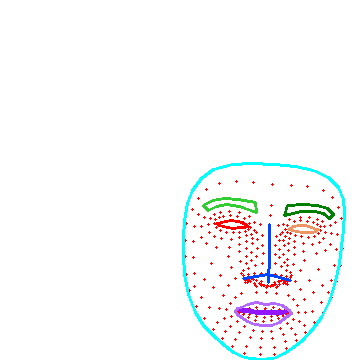

z_values: [17.22889     4.7107353   1.5076945   2.9703145   0.33141816  2.9251266
  0.56492317  1.0483648 ]
Emotion Label: sad


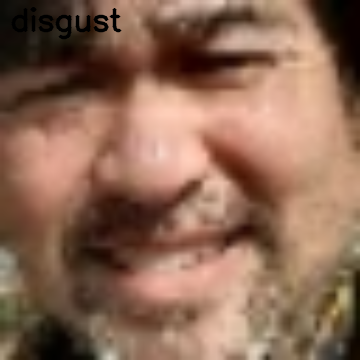

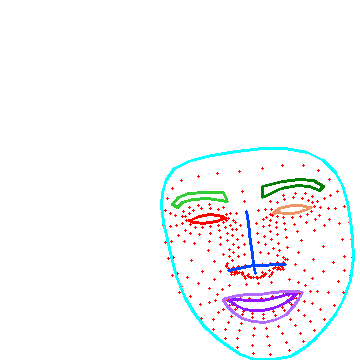

z_values: [6.114101   4.447291   1.4982855  2.7299619  0.28282017 3.1453462
 0.64297867 1.169678  ]
Emotion Label: disgust


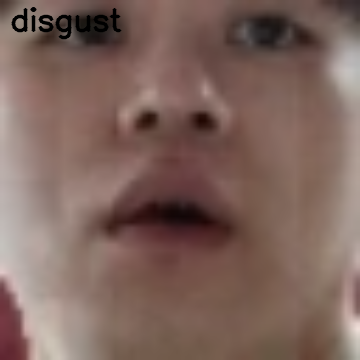

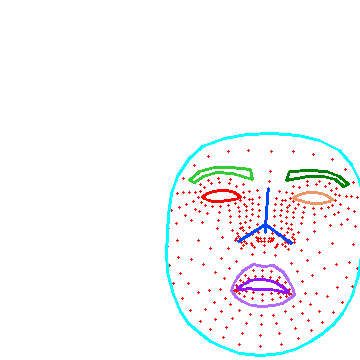

z_values: [5.0997753  3.9299586  1.8296366  2.5124812  0.34547216 3.2390227
 0.55840635 1.0172354 ]
Emotion Label: disgust


In [ ]:
#시각화 코드
import tensorflow as tf
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

tfrecord_filename = '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_train_AUGX.tfrecord'

emotion_labels = {
    0: "happy",
    1: "sad",
    2: "anger",
    3: "surprise",
    4: "disgust",
    5: "neutral",
    6: "fear"
}
landmark_colors = {
    "Left Eyebrow": ([70,63,105,66,107,55,65,52,53,46,70], (50, 205, 50)),
    "Right Eyebrow": ([300,293,334,296,336,285,295,282,283,276,300], (0, 128, 0)),
    "Left Eye": ([33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7,33], (0, 0, 255)),
    "Right Eye": ([263,466,388,387,386,385,384,398,362,382,381,380,374,373,390,249,263], (100, 149, 237)),
    "Inner Lip": ([78,191,80,81,82,13,312,311,310,415,308,324,318,402,317,14,87,178,88,95,78], (255, 20, 147)),
    "Outer Lip": ([61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146,61], (255, 105, 180)),
    "Face Boundary": ([10,338,297,332,284,251,389,356,454,323,361,288,397,365,379,378,400,377,152,148,176,149,150,136,172,58,132,93,234,127,162,21,54,103,67,109,10], (255, 255, 0)),
    "Nose": ([64,4,294], (255, 69, 0)),
    "Nose Bridge": ([168,6,197,195,5,4,1],(255,69,0))}
# 랜드마크 시각화를 위한 빈 이미지 생성 함수
def create_blank_image(width=360, height=360, color=(255, 255, 255)):
    return np.zeros((height, width, 3), np.uint8) + np.array(color, np.uint8)

# TFRecord 파일을 읽어서 파싱하는 함수
def read_tfrecord(file_path):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'landmarks': tf.io.FixedLenFeature([468 * 3], tf.float32),
        'z_values': tf.io.FixedLenFeature([8], tf.float32),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    def _parse_function(example_proto):
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.io.decode_jpeg(parsed_features['image'], channels=3)
        image = tf.image.resize(image, [64, 64])

        landmarks = parsed_features['landmarks']
        z_values = parsed_features['z_values']
        label = parsed_features['label']
        return image, landmarks, z_values, label

    raw_dataset = tf.data.TFRecordDataset(file_path)
    parsed_dataset = raw_dataset.map(_parse_function)

    return parsed_dataset

# 빈 이미지 생성 함수
def visualize_data(image, landmarks, z_values, label):
    image = image.numpy().astype(np.uint8)
    image = cv2.resize(image, (360, 360))
    image_landmark = create_blank_image()

    center_x, center_y = 360 / 2, 360 / 2

    # landmarks 배열에서 각 랜드마크 포인트를 가져와 시각화
    for i in range(0, len(landmarks), 3):
        x = landmarks[i] * center_x + center_x
        y = landmarks[i + 1] * center_y + center_y
        cv2.circle(image_landmark, (int(x), int(y)), 1, (0, 0, 255), -1)

    # 각 랜드마크 범주별로 선으로 연결
    for category, (indices, color) in landmark_colors.items():
        for i in range(len(indices) - 1):
            pt1_index, pt2_index = indices[i], indices[i + 1]
            pt1_x = landmarks[pt1_index * 3] * center_x + center_x
            pt1_y = landmarks[pt1_index * 3 + 1] * center_y + center_y
            pt2_x = landmarks[pt2_index * 3] * center_x + center_x
            pt2_y = landmarks[pt2_index * 3 + 1] * center_y + center_y

            pt1 = (int(pt1_x), int(pt1_y))
            pt2 = (int(pt2_x), int(pt2_y))
            cv2.line(image_landmark, pt1, pt2, color, 2)


    # 감정 레이블 및 나머지 시각화 코드
    label_scalar = label.numpy()
    emotion = emotion_labels.get(label_scalar, 'Unknown')
    cv2.putText(image, emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

    # 이미지 출력
    cv2_imshow(image)

    # 랜드마크 출력
    cv2_imshow(image_landmark)

    # z_values 출력
    print('z_values:', z_values.numpy())

    # 감정 레이블 출력
    print('Emotion Label:', emotion)

# 데이터셋 시각화
for image, landmarks, z_values, label in read_tfrecord(tfrecord_filename).take(10):
    visualize_data(image, landmarks, z_values, label)

# OpenCV 창 닫기
cv2.destroyAllWindows()


# 평균얼굴 시각화
YES AUG

happy:
  인덱스 0 평균 좌표: (267.94748532030457, 294.0292009086361)
  인덱스 1 평균 좌표: (267.76882312168067, 272.47817379837255)
  인덱스 2 평균 좌표: (267.8168796759859, 278.85784928560594)
  인덱스 3 평균 좌표: (261.24744974172233, 245.44109218703147)
  인덱스 4 평균 좌표: (267.72834427023474, 264.38831768720416)
  인덱스 5 평균 좌표: (267.61199429254594, 253.41181324701392)
  인덱스 6 평균 좌표: (267.3810848386825, 226.70085555977587)
  인덱스 7 평균 좌표: (215.0772817377976, 223.05810037561375)
  인덱스 8 평균 좌표: (267.1976008200696, 205.94938270166787)
  인덱스 9 평균 좌표: (267.1421466399635, 195.14089015146388)
  인덱스 10 평균 좌표: (266.86866943762584, 157.22427832487216)
  인덱스 11 평균 좌표: (267.9595894926954, 297.4948623564775)
  인덱스 12 평균 좌표: (267.973829133389, 299.8043332188717)
  인덱스 13 평균 좌표: (268.007967471652, 300.3024091347442)
  인덱스 14 평균 좌표: (268.1333164379515, 307.42848213423866)
  인덱스 15 평균 좌표: (268.17474738193096, 310.53453354696103)
  인덱스 16 평균 좌표: (268.1940065115828, 314.3655830156489)
  인덱스 17 평균 좌표: (268.217980741245, 318.581591765570

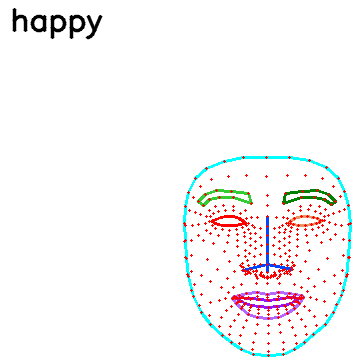

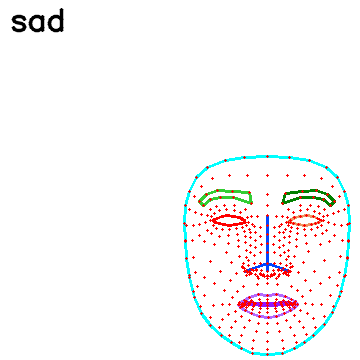

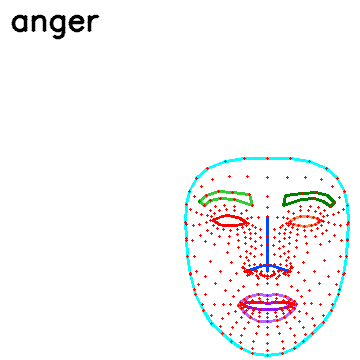

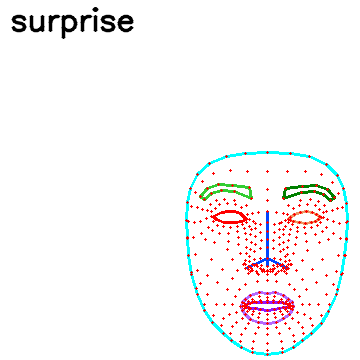

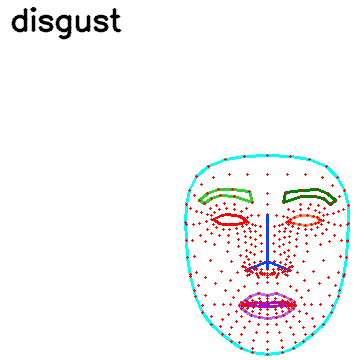

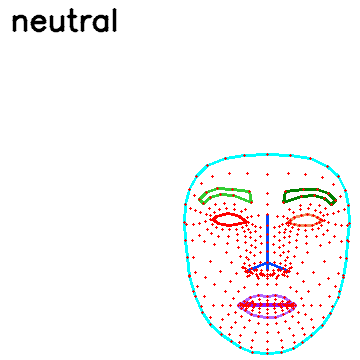

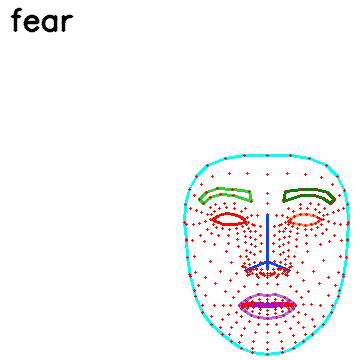

In [ ]:
#평균얼굴 시각화
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# TFRecord 파일 경로
tfrecord_file = "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_train.tfrecord"

emotion_labels = {
    0: "happy",
    1: "sad",
    2: "anger",
    3: "surprise",
    4: "disgust",
    5: "neutral",
    6: "fear",
}
# TFRecord 파싱 함수
def _parse_function(proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "landmarks": tf.io.VarLenFeature(tf.float32),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(proto, feature_description)

# 이미지 디코딩 함수
def decode_image(image_str):
    return tf.image.decode_image(image_str, channels=3)

# 랜드마크 시각화를 위한 빈 이미지 생성 함수
def create_blank_image(width=360, height=360, color=(255, 255, 255)):
    return np.zeros((height, width, 3), np.uint8) + np.array(color, np.uint8)

# 주요 랜드마크 인덱스 및 색상
landmark_colors = {
    "Left Eyebrow": ([70,63,105,66,107,55,65,52,53,46,70], (50, 205, 50)),
    "Right Eyebrow": ([300,293,334,296,336,285,295,282,283,276,300], (0, 128, 0)),
    "Left Eye": ([33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7,33], (0, 0, 255)),
    "Right Eye": ([263,466,388,387,386,385,384,398,362,382,381,380,374,373,390,249,263], (100, 149, 237)),
    "Inner Lip": ([78,191,80,81,82,13,312,311,310,415,308,324,318,402,317,14,87,178,88,95,78], (255, 20, 147)),
    "Outer Lip": ([61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146,61], (255, 105, 180)),
    "Face Boundary": ([10,338,297,332,284,251,389,356,454,323,361,288,397,365,379,378,400,377,152,148,176,149,150,136,172,58,132,93,234,127,162,21,54,103,67,109,10], (255, 255, 0)),
    "Nose": ([64,4,294], (255, 69, 0)),
    "Nose Bridge": ([168,6,197,195,5,4,1],(255,69,0))}
# TFRecord 파일 로드 및 파싱
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
parsed_dataset = raw_dataset.map(_parse_function)

# 각 감정별로 각 인덱스의 랜드마크 포인트의 합계와 개수를 저장할 딕셔너리
emotion_landmarks_sum = {emotion: {i: np.array([0.0, 0.0]) for i in range(468)} for emotion in emotion_labels.values()}
emotion_landmarks_count = {emotion: {i: 0 for i in range(468)} for emotion in emotion_labels.values()}

# 랜드마크 시각화 및 감정별 랜드마크 포인트 수집
for idx, parsed_record in enumerate(parsed_dataset):
    landmarks = tf.sparse.to_dense(parsed_record["landmarks"]).numpy()
    label = parsed_record["label"].numpy()  # 정수 레이블
    emotion = emotion_labels.get(label, "Unknown")  # 레이블에 해당하는 감정

    # 이미지 중앙을 원점으로 설정
    center_x, center_y = 360 / 2, 360 / 2  # 가정한 이미지 크기

    # 모든 랜드마크 포인트 수집
    for i in range(468):
        x = landmarks[i * 3] * center_x + center_x
        y = landmarks[i * 3 + 1] * center_y + center_y
        emotion_landmarks_sum[emotion][i] += np.array([x, y])
        emotion_landmarks_count[emotion][i] += 1


# 각 감정별로 평균 랜드마크 좌표를 저장할 딕셔너리
emotion_avg_landmarks = {emotion: np.zeros((468, 2)) for emotion in emotion_labels.values()}

# 평균 좌표 계산 및 출력
for emotion, landmarks in emotion_landmarks_sum.items():
    for i, sum_points in landmarks.items():
        if emotion_landmarks_count[emotion][i] > 0:
            emotion_avg_landmarks[emotion][i] = sum_points / emotion_landmarks_count[emotion][i]

    # 평균 좌표 출력
    print(f"{emotion}:")
    for i, avg_point in enumerate(emotion_avg_landmarks[emotion]):
        print(f"  인덱스 {i} 평균 좌표: ({avg_point[0]}, {avg_point[1]})")

# 각 감정별로 랜드마크 시각화
for emotion, avg_landmarks in emotion_avg_landmarks.items():
    # 빈 이미지 생성
    image = create_blank_image()

    # 주요 랜드마크 포인트에 선 연결
    for category, (indices, color) in landmark_colors.items():
        for i in range(len(indices) - 1):
            pt1 = tuple(avg_landmarks[indices[i]].astype(int))
            pt2 = tuple(avg_landmarks[indices[i + 1]].astype(int))
            cv2.line(image, pt1, pt2, color, 2)

    # 각 랜드마크 포인트에 점 찍기
    for pt in avg_landmarks:
        cv2.circle(image, tuple(pt.astype(int)), 1, (0, 0, 255), -1)

    # 감정 레이블 표시
    cv2.putText(image, emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

    # 이미지 출력
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


#그래프 YES AUG


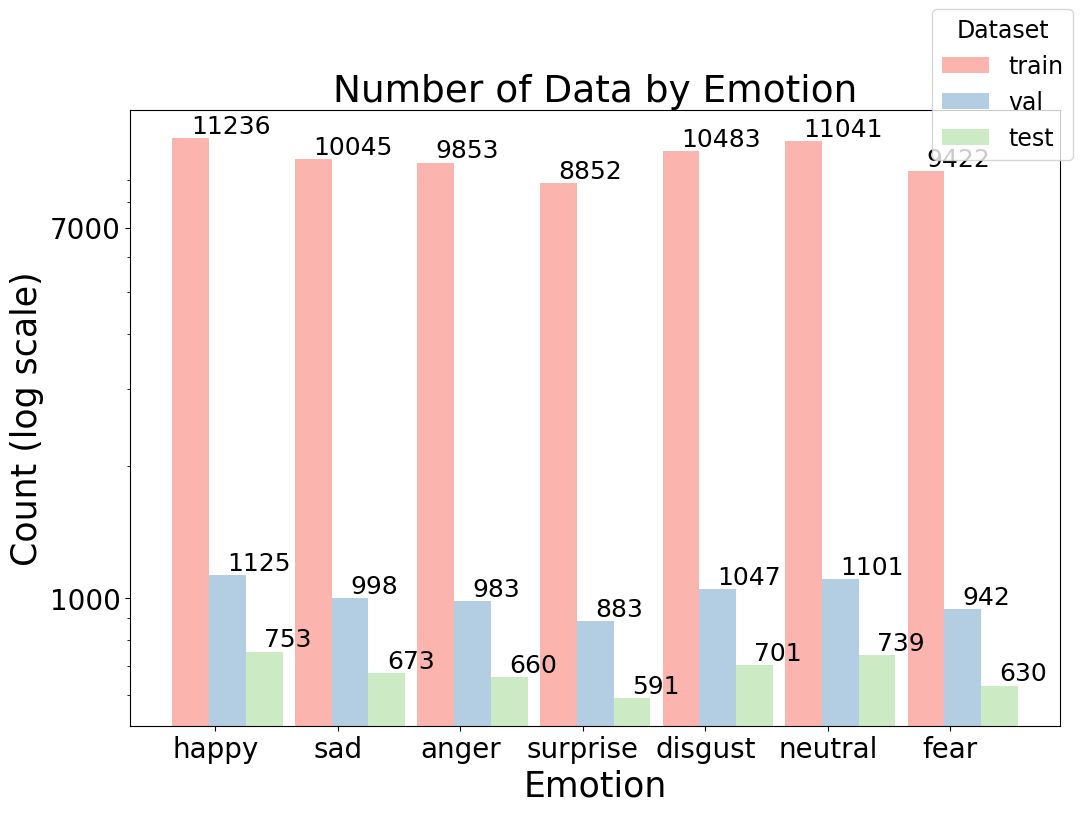

In [ ]:
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl


# TFRecord 파일 경로 리스트
tfrecord_paths = [
    '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_train.tfrecord',
    '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_val.tfrecord',
    '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_test.tfrecord'
]

# 감정 레이블 정의
emotion_labels = {
    "happy": 0, "sad": 1, "anger": 2, "surprise": 3, "disgust": 4, "neutral": 5, "fear": 6,
}

# TFRecord 파싱 함수
def parse_tfrecord_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    return tf.io.parse_single_example(example_proto, feature_description)

# 각 TFRecord 파일에 대해 처리
emotion_counts = []
for tfrecord_path in tfrecord_paths:
    # TFRecord 데이터셋 로드
    dataset = tf.data.TFRecordDataset(tfrecord_path).map(parse_tfrecord_function)

    # 레이블 별 데이터 카운트
    label_count = Counter()
    for record in dataset:
        label = record['label'].numpy()
        label_count[label] += 1

    # 감정 레이블로 변환하여 저장
    emotion_count = {emotion: label_count[label] for emotion, label in emotion_labels.items()}
    emotion_counts.append(emotion_count)

# 글자 크기 설정
mpl.rcParams['font.size'] = 20

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
for i, emotion_count in enumerate(emotion_counts):
    # 감정 레이블과 개수를 분리
    emotions = list(emotion_count.keys())
    counts = list(emotion_count.values())

    # 막대 그래프 추가 (바의 위치를 조정하여 겹치지 않게 함)
    bars = plt.bar([x + 0.3* i for x in range(len(emotions))], counts, color=plt.cm.Pastel1.colors[i], width=0.3)

    # 레이블 추가
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', fontsize=18)  # va: vertical alignment

# 그래프 제목 및 레이블 설정
plt.title('Number of Data by Emotion', fontsize=27)
plt.xticks([x + 0.2 for x in range(len(emotions))], emotions)
plt.xlabel('Emotion', fontsize=25)
plt.ylabel('Count (log scale)', fontsize=25)

# y축을 로그 스케일로 조정
plt.yscale('log')

# y축 레이블 설정
plt.yticks([1000, 7000], ['1000', '7000'])

# 레전드 설정
labels = ['train', 'val', 'test']
plt.legend(labels, title='Dataset', title_fontsize='17', fontsize='17', bbox_to_anchor=(0.85, 0.9))

# 그래프 출력
plt.show()

#그래프 AUGX


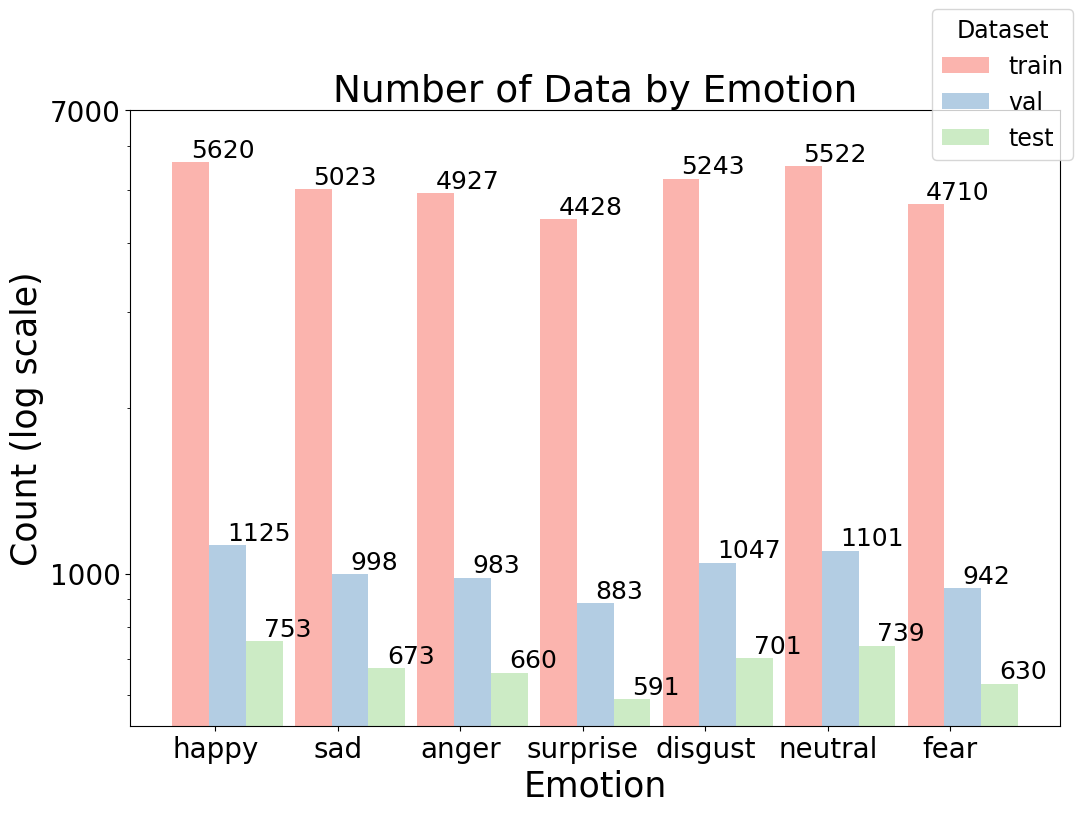

In [ ]:
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl


# TFRecord 파일 경로 리스트
tfrecord_paths = [
    '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_train_AUGX.tfrecord',
    '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_val.tfrecord',
    '/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_test.tfrecord'
]

# 감정 레이블 정의
emotion_labels = {
    "happy": 0, "sad": 1, "anger": 2, "surprise": 3, "disgust": 4, "neutral": 5, "fear": 6,
}

# TFRecord 파싱 함수
def parse_tfrecord_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    return tf.io.parse_single_example(example_proto, feature_description)

# 각 TFRecord 파일에 대해 처리
emotion_counts = []
for tfrecord_path in tfrecord_paths:
    # TFRecord 데이터셋 로드
    dataset = tf.data.TFRecordDataset(tfrecord_path).map(parse_tfrecord_function)

    # 레이블 별 데이터 카운트
    label_count = Counter()
    for record in dataset:
        label = record['label'].numpy()
        label_count[label] += 1

    # 감정 레이블로 변환하여 저장
    emotion_count = {emotion: label_count[label] for emotion, label in emotion_labels.items()}
    emotion_counts.append(emotion_count)

# 글자 크기 설정
mpl.rcParams['font.size'] = 20

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
for i, emotion_count in enumerate(emotion_counts):
    # 감정 레이블과 개수를 분리
    emotions = list(emotion_count.keys())
    counts = list(emotion_count.values())

    # 막대 그래프 추가 (바의 위치를 조정하여 겹치지 않게 함)
    bars = plt.bar([x + 0.3* i for x in range(len(emotions))], counts, color=plt.cm.Pastel1.colors[i], width=0.3)

    # 레이블 추가
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', fontsize=18)  # va: vertical alignment

# 그래프 제목 및 레이블 설정
plt.title('Number of Data by Emotion', fontsize=27)
plt.xticks([x + 0.2 for x in range(len(emotions))], emotions)
plt.xlabel('Emotion', fontsize=25)
plt.ylabel('Count (log scale)', fontsize=25)

# y축을 로그 스케일로 조정
plt.yscale('log')

# y축 레이블 설정
plt.yticks([1000, 7000], ['1000', '7000'])

# 레전드 설정
labels = ['train', 'val', 'test']
plt.legend(labels, title='Dataset', title_fontsize='17', fontsize='17', bbox_to_anchor=(0.85, 0.9))

# 그래프 출력
plt.show()

#그래프 external


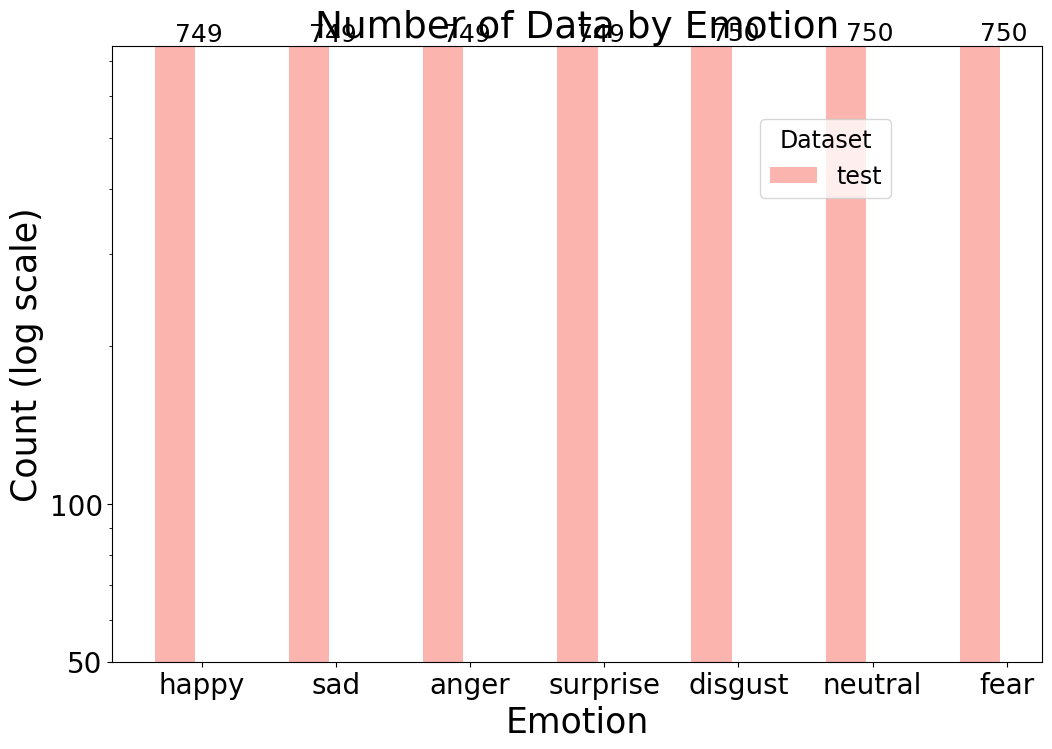

In [ ]:
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl


# TFRecord 파일 경로 리스트
tfrecord_paths = [
    '/content/drive/MyDrive/clean_0317/External/ext_YES_Z_test_shuffled.tfrecord'
]

# 감정 레이블 정의
emotion_labels = {
    "happy": 0, "sad": 1, "anger": 2, "surprise": 3, "disgust": 4, "neutral": 5, "fear": 6,
}

# TFRecord 파싱 함수
def parse_tfrecord_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    return tf.io.parse_single_example(example_proto, feature_description)

# 각 TFRecord 파일에 대해 처리
emotion_counts = []
for tfrecord_path in tfrecord_paths:
    # TFRecord 데이터셋 로드
    dataset = tf.data.TFRecordDataset(tfrecord_path).map(parse_tfrecord_function)

    # 레이블 별 데이터 카운트
    label_count = Counter()
    for record in dataset:
        label = record['label'].numpy()
        label_count[label] += 1

    # 감정 레이블로 변환하여 저장
    emotion_count = {emotion: label_count[label] for emotion, label in emotion_labels.items()}
    emotion_counts.append(emotion_count)

# 글자 크기 설정
mpl.rcParams['font.size'] = 20

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
for i, emotion_count in enumerate(emotion_counts):
    # 감정 레이블과 개수를 분리
    emotions = list(emotion_count.keys())
    counts = list(emotion_count.values())

    # 막대 그래프 추가 (바의 위치를 조정하여 겹치지 않게 함)
    bars = plt.bar([x + 0.3* i for x in range(len(emotions))], counts, color=plt.cm.Pastel1.colors[i], width=0.3)

    # 레이블 추가
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', fontsize=18)  # va: vertical alignment

# 그래프 제목 및 레이블 설정
plt.title('Number of Data by Emotion', fontsize=27)
plt.xticks([x + 0.2 for x in range(len(emotions))], emotions)
plt.xlabel('Emotion', fontsize=25)
plt.ylabel('Count (log scale)', fontsize=25)

# y축을 로그 스케일로 조정
plt.yscale('log')

# y축 레이블 설정
plt.yticks([50, 100], ['50', '100'])

# 레전드 설정
labels = ['test']
plt.legend(labels, title='Dataset', title_fontsize='17', fontsize='17', bbox_to_anchor=(0.85, 0.9))

# 그래프 출력
plt.show()